In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
states = ShapelyFeature(Reader('/glade/work/mazrooei/DATA/useful_shapefiles/states.shp').geometries(),
                                ccrs.PlateCarree(), facecolor='none', edgecolor='black')
proj = ccrs.Orthographic(central_longitude=-100, central_latitude=35)
ncproj = ccrs.PlateCarree()
# Define the projection of NWM
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
nwm_proj = ccrs.LambertConformal(globe=globe, central_longitude=-97.0, central_latitude=40.0, standard_parallels=(30.0,60.0))
extent_conus = [-122, -73, 22, 50]


In [3]:
%%time
list_basins = pd.read_csv('/glade/u/home/mazrooei/work/USGS/usgs_ealstm/ealstm_regional_modeling/data/basin_list.txt', dtype=str, names=['site_no']).site_no.to_list()
data_LSTM = pd.read_pickle('/glade/u/home/mazrooei/work/USGS/usgs_ealstm/ealstm_regional_modeling/runs/run_conus404_gagesII_trained_on_2005_2020/ealstm_seed95734.p')

usgs_meta = pd.read_csv("/glade/p/cisl/nwc/nwm_verification_obs/streamflow_usgs/obsStrMeta.csv", dtype={'site_no': str}, index_col=0).set_index('site_no')
usgs_meta = usgs_meta.sort_index()
usgs_short_columns = ['station_nm', 'dec_lat_va', 'dec_long_va']
usgs_short = usgs_meta[usgs_short_columns]



CPU times: user 515 ms, sys: 41.1 ms, total: 556 ms
Wall time: 915 ms


In [25]:
def my_verif(obs, sim):
    # sim = df.qsim
    # obs = df.qobs

    sim_log = np.log(sim+0.0001)
    sim_mean = np.mean(sim)
    sim_std = np.std(sim)
    
    obs_log = np.log(obs+0.0001)
    obs_mean = np.mean(obs)
    obs_std = np.std(obs)

    Bias = sim_mean - obs_mean
    Bias_perc = 100*Bias / obs_mean
    Err = sim-obs
    MSE = np.mean(Err**2)
    RMSE = np.sqrt(MSE)
    RRMSE = RMSE / obs_mean
    
    corr_pear = obs.corr(sim) 
    corr_rank = obs.corr(sim, method='spearman')

    if obs_std != 0:
        KGE_alpha = np.float64(sim_std)  / obs_std
        NSE_C = (Bias / obs_std)**2
    else:
        KGE_alpha = np.nan
        NSE_C = np.nan
    
    if obs_mean != 0:
        KGE_beta = np.float64(sim_mean) / obs_mean
    else:
        KGE_beta = np.nan
    
    NSE_A = corr_pear**2
    NSE_B = (corr_pear - KGE_alpha)**2

    NSE = 1-( np.sum(Err**2) / np.sum((obs-obs_mean)**2) )
    KGE = 1-( np.sqrt( (corr_pear-1)**2 + (KGE_alpha-1)**2 + (KGE_beta-1)**2 ) )
    LogNSE = 1-( np.sum((sim_log-obs_log)**2) / np.sum((obs_log-np.mean(obs_log))**2))
    WtNSE = (0.5*NSE) + (0.5*LogNSE)
    
    out_df = pd.DataFrame({'mean_obs':obs_mean,
                           'mean_sim':sim_mean, 
                           'std_obs':obs_std,
                           'std_sim':sim_std, 
                           'Bias': Bias,
                           'Bias_perc': Bias_perc,
                           'corr_pear': corr_pear,
                           'corr_rank': corr_rank,
                           'NSE': NSE,
                           'KGE': KGE,
                           'LogNSE': LogNSE,
                           'WtNSE': WtNSE,
                           'MSE': MSE,
                           'RMSE': RMSE,
                           'RRMSE': RRMSE,
                           'NSE_A':NSE_A, 
                           'NSE_B':NSE_B, 
                           'NSE_C':NSE_C, 
                           'KGE_alpha':KGE_alpha, 
                           'KGE_beta':KGE_beta
                           }, index=[0])
    return out_df.round(4)


   mean_obs  mean_sim  std_obs  std_sim    Bias  Bias_perc  corr_pear  \
0    0.0268     1.713      0.0   2.2137  1.6862  6284.2621        NaN   

   corr_rank  NSE  KGE  LogNSE  WtNSE     MSE    RMSE    RRMSE  NSE_A  NSE_B  \
0        NaN -inf  NaN    -inf   -inf  3.5463  1.8832  70.1829    NaN    NaN   

   NSE_C  KGE_alpha  KGE_beta  
0    NaN        NaN   63.8426  


/glade/work/mazrooei/miniconda3/envs/myxr/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/glade/work/mazrooei/miniconda3/envs/myxr/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/glade/scratch/mazrooei/ipykernel_54447/207634639.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  NSE = 1-( np.sum(Err**2) / np.sum((obs-obs_mean)**2) )
/glade/scratch/mazrooei/ipykernel_54447/207634639.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  LogNSE = 1-( np.sum((sim_log-obs_log)**2) / np.sum((obs_log-np.mean(obs_log))**2))


<AxesSubplot:>

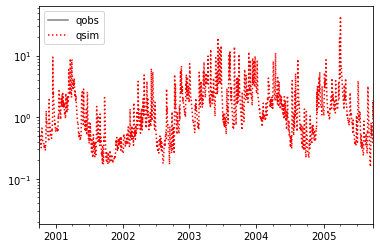

In [24]:
s
df = data_LSTM[s]
df
# obs = df.qobs
# sim = df.qsim
print(my_verif(obs = df.qobs, sim = df.qsim))
df.plot.line( y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=True, legend=True)
# verif = my_verif(df.qobs, df.qsim)

In [26]:
## Compute verif metrics for all sites
Metrics = pd.DataFrame()
for s in tqdm(list_basins):
    df = data_LSTM[s]
    verif = my_verif(df.qobs, df.qsim)
    verif.index = pd.Index([s], name='site_no') 
    Metrics = Metrics.append(verif)

Metrics = usgs_short.loc[list_basins].join(Metrics)
Metrics = Metrics.rename(columns={'Bias':'Bias [mm/day]'})
display(Metrics)

  0%|          | 0/1291 [00:00<?, ?it/s]/glade/scratch/mazrooei/ipykernel_54447/1590787283.py:38: RuntimeWarning: invalid value encountered in double_scalars
  NSE = 1-( np.sum(Err**2) / np.sum((obs-obs_mean)**2) )
/glade/scratch/mazrooei/ipykernel_54447/1590787283.py:40: RuntimeWarning: invalid value encountered in double_scalars
  LogNSE = 1-( np.sum((sim_log-obs_log)**2) / np.sum((obs_log-np.mean(obs_log))**2))
  5%|▌         | 71/1291 [00:00<00:13, 91.32it/s]/glade/work/mazrooei/miniconda3/envs/myxr/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/glade/work/mazrooei/miniconda3/envs/myxr/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/glade/scratch/mazrooei/ipykernel_54447/1590787283.py:38: RuntimeWarning: divide by zero encountered in double_scalars
  NSE = 1-( np.sum(Err**2) / np.

,station_nm,dec_lat_va,dec_long_va,mean_obs,mean_sim,std_obs,std_sim,Bias [mm/day],Bias_perc,corr_pear,...,LogNSE,WtNSE,MSE,RMSE,RRMSE,NSE_A,NSE_B,NSE_C,KGE_alpha,KGE_beta
site_no,,,,,,,,,,,,,,,,,,,,,
01013500,"Fish River near Fort Kent, Maine",47.237500,-68.582778,1.5118,1.4420,1.8889,1.9428,-0.0699,-4.6232,0.8776,...,0.5700,0.6580,0.9065,0.9521,0.6297,0.7701,0.0228,0.0014,1.0285,0.9538
01021480,"Old Stream near Wesley, Maine",44.936944,-67.736111,1.6550,1.7702,2.3425,2.1194,0.1151,6.9568,0.8511,...,0.5887,0.6539,1.5414,1.2415,0.7501,0.7244,0.0029,0.0024,0.9048,1.0696
01027200,"North Branch Penobscot River nr Pittston Farm, ME",45.935278,-69.993611,1.5904,1.7157,2.7083,2.8187,0.1253,7.8778,0.8593,...,0.6419,0.6721,2.1835,1.4777,0.9291,0.7384,0.0329,0.0021,1.0408,1.0788
01029200,"Seboeis River near Shin Pond, Maine",46.143056,-68.633611,1.3594,1.4084,2.0812,2.1378,0.0490,3.6045,0.9102,...,0.6522,0.7332,0.8049,0.8971,0.6600,0.8284,0.0137,0.0006,1.0272,1.0360
01030500,"Mattawamkeag River near Mattawamkeag, Maine",45.501111,-68.305833,1.4703,1.5302,2.1520,1.9815,0.0599,4.0738,0.9121,...,0.7127,0.7719,0.7826,0.8846,0.6017,0.8319,0.0001,0.0008,0.9208,1.0407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14318000,"LITTLE RIVER AT PEEL, OR",43.252618,-123.026172,1.8202,1.6577,2.8367,2.6093,-0.1625,-8.9266,0.9277,...,0.9433,0.9003,1.1479,1.0714,0.5886,0.8607,0.0001,0.0033,0.9198,0.9107
14325000,"SOUTH FORK COQUILLE RIVER AT POWERS, OR",42.891499,-124.070652,3.2500,3.6196,5.7782,6.0024,0.3696,11.3729,0.9290,...,0.9487,0.8979,5.1089,2.2603,0.6955,0.8631,0.0120,0.0041,1.0388,1.1137
14362250,"STAR GULCH NEAR RUCH, OR",42.154014,-123.075323,0.2533,0.3184,0.7511,0.5874,0.0651,25.7012,0.8580,...,0.1927,0.4578,0.1563,0.3954,1.5608,0.7362,0.0058,0.0075,0.7820,1.2570


(-0.5, 0.5)

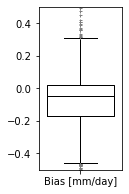

In [33]:
flierprops = dict(marker='+', markerfacecolor=None, markersize=3,
                  linestyle='none', markeredgecolor='grey')

var = Metrics['Bias [mm/day]']
plt.figure(figsize=(1.5,3))
plt.boxplot(var[var.notna()], widths=.8, flierprops=flierprops, labels=['Bias [mm/day]'], medianprops=dict(color='k'))
plt.ylim((-.50,.50))


(-50.0, 50.0)

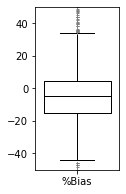

In [35]:
var = Metrics['Bias_perc']
plt.figure(figsize=(1.5,3))
plt.boxplot(var[var.notna()], labels=['%Bias'], widths=.8, medianprops=dict(color='k'), flierprops=flierprops)
plt.ylim((-50,50))

(-1.0, 1.0)

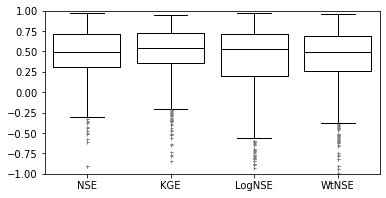

In [37]:


plt.figure(figsize=(6,3))
Metrics.boxplot(column=['NSE', 'KGE', 'LogNSE', 'WtNSE'], widths=.8, grid=False, color='k', flierprops=flierprops) #showfliers=Fals
plt.ylim((-1,1))

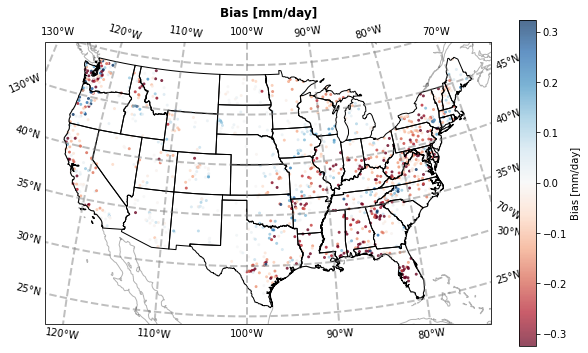

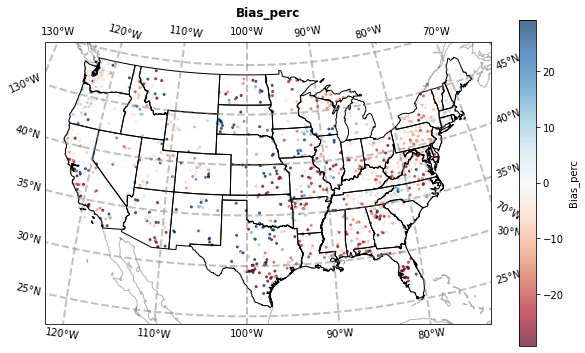

In [38]:
for varname in ['Bias [mm/day]', 'Bias_perc']:
    var = Metrics[varname]
    cmax = np.max([np.abs(var.quantile(.1)), np.abs(var.quantile(.9))])
    cmin = -1 * cmax
    fig = plt.figure(figsize=(10,6))
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(wspace=0.15, hspace=.25) # set the spacing between axes. 

    ax1 = plt.subplot(gs1[0],projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states)
    Metrics.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=varname, 
                         s=4, vmin=cmin, vmax=cmax, cmap='RdBu', alpha=.7)
    # sc1 = ax1.scatter(Metrics.dec_long_va, Metrics.dec_lat_va, transform=ccrs.PlateCarree(), s=7, c=var, vmin=cmin, vmax=cmax, cmap='nipy_spectral_r')
    # plt.colorbar(sc1, orientation='vertical',ticklocation='auto')
    ax1.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax1.set_title(varname, fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())

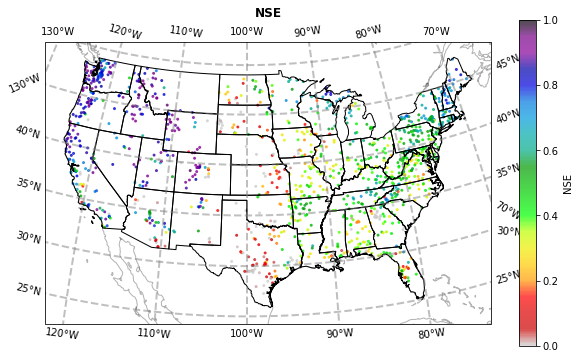

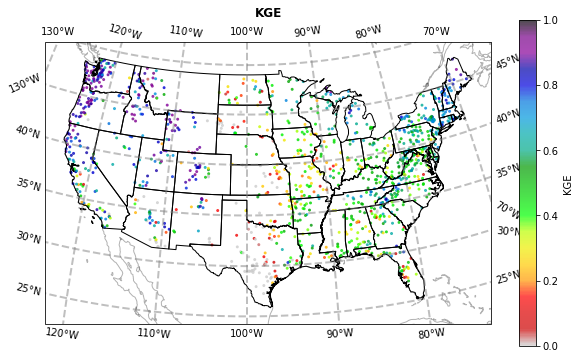

In [39]:
for varname in ['NSE', 'KGE']:
    var = Metrics[varname]
    cmin = 0
    cmax = 1
    fig = plt.figure(figsize=(10,6))
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(wspace=0.15, hspace=.25) # set the spacing between axes. 

    ax1 = plt.subplot(gs1[0],projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states)
    Metrics.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=varname, 
                         s=4, vmin=cmin, vmax=cmax, cmap='nipy_spectral_r', alpha=.7)
    # sc1 = ax1.scatter(Metrics.dec_long_va, Metrics.dec_lat_va, transform=ccrs.PlateCarree(), s=7, c=var, vmin=cmin, vmax=cmax, cmap='nipy_spectral_r')
    # plt.colorbar(sc1, orientation='vertical',ticklocation='auto')
    ax1.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax1.set_title(varname, fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())



### Hydrograph, single basin

In [126]:
Metrics.NSE.idxmin()

'07227420'

                qobs      qsim       err        %err
2000-10-01  0.561963  0.358151 -0.203813   -0.362680
2000-10-02  0.449274  0.234173 -0.215101   -0.478775
2000-10-03  0.339550  0.184225 -0.155326   -0.457445
2000-10-04  0.268378  0.135186 -0.133192   -0.496284
2000-10-05  0.210551  0.166549 -0.044002   -0.208983
...              ...       ...       ...         ...
2005-09-26  0.001483  0.626912  0.625429  421.802776
2005-09-27  0.001483  0.627276  0.625793  422.048422
2005-09-28  0.001483  0.140409  0.138927   93.695040
2005-09-29  0.001483  0.166517  0.165034  111.302502
2005-09-30  0.000000  0.108077  0.108077         inf

[1826 rows x 4 columns]


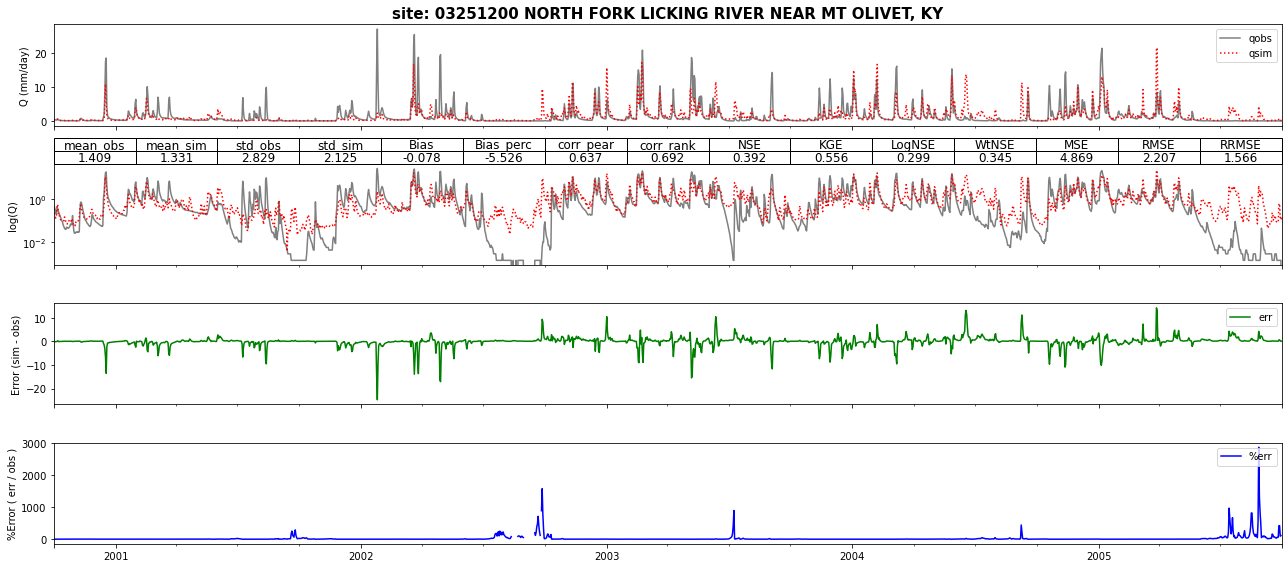

In [42]:
s = '03251200'
df = data_LSTM[s]
df['err'] = df.qsim - df.qobs
df['%err'] = df.err / df.qobs
verif = my_verif(df.qobs, df.qsim).iloc[:, :15]
print(df)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(18,8))
df.plot.line(ax=axes[0], use_index=True, sharex=True,  y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=False).legend(loc='upper right')
df.plot.line(ax=axes[1], y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=True, legend=False)
df.plot.line(ax=axes[2], y=['err'], color={"err":"green"}, style=['-'], legend=True).legend(loc='upper right')
df.plot.line(ax=axes[3], y=['%err'], color={"%err":"blue"}, style=['-'], legend=True).legend(loc='upper right')
axes[0].set_ylabel('Q (mm/day)')
axes[1].set_ylabel('log(Q)')
axes[2].set_ylabel('Error (sim - obs)')
axes[3].set_ylabel('%Error ( err / obs )')
axes[1].set_xlabel('Date')
axes[0].set_title('site: '+s+' '+usgs_short.station_nm.loc[s], fontsize=15, fontweight='bold')
# axes[3].axis('off')

tbl = axes[1].table(cellText=verif.values.round(3), colLabels=list(verif.columns), loc='top', cellLoc='center' ) #pd.plotting.table(ax=axes[3], data=verif.iloc[:, :10], fontsize=47)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
plt.tight_layout()

<AxesSubplot:>

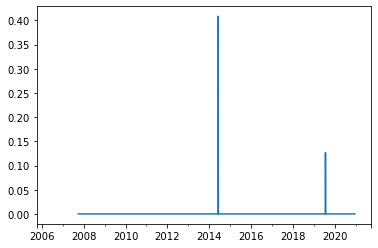

In [27]:
df.qobs.plot()

In [127]:
verif.iloc[:, :10]

,mean_obs,mean_sim,std_obs,std_sim,Bias,Bias_perc,corr_pear,corr_rank,NSE,KGE
0,2.701746,2.461445,5.144389,4.890418,-0.2403,-8.894261,0.94638,0.980782,0.893435,0.885008
